In [6]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import json
from scipy import stats
import pandas as pd
from config import apikey, email
from g_key import gkey
import gmaps
import os

In [7]:
# base url for state codes needed down the line to focus in 
state_url = (f'https://aqs.epa.gov/data/api/list/states?email={email}&key={apikey}')

# get the state codes into a data frame
response=requests.get(state_url)
data=response.json()


In [130]:
# parameter classes
param_url=f'https://aqs.epa.gov/data/api/list/parametersByClass?email={email}&key={apikey}&pc=CRITERIA'

response=requests.get(param_url)
data_param=response.json()
data_param

{'Header': [{'status': 'Success',
   'request_time': '2021-02-05T00:29:56-05:00',
   'url': 'https://aqs.epa.gov/data/api/list/parametersByClass?email=erich.mitchell87@gmail.com&key=goldmouse56&pc=CRITERIA',
   'rows': 8}],
 'Data': [{'code': '14129', 'value_represented': 'Lead (TSP) LC'},
  {'code': '42101', 'value_represented': 'Carbon monoxide'},
  {'code': '42401', 'value_represented': 'Sulfur dioxide'},
  {'code': '42602', 'value_represented': 'Nitrogen dioxide (NO2)'},
  {'code': '44201', 'value_represented': 'Ozone'},
  {'code': '81102', 'value_represented': 'PM10 Total 0-10um STP'},
  {'code': '85129', 'value_represented': 'Lead PM10 LC FRM/FEM'},
  {'code': '88101', 'value_represented': 'PM2.5 - Local Conditions'}]}

In [9]:
# pulling sample data
# Choose state
state='53'

# choose parameter 
param='42101'

# create the begin date and end date for search using yyyymmdd format
bdate='20200131'
edate='20201231'

# develop the query URL - Sample Data
sample_url=f'https://aqs.epa.gov/data/api/sampleData/byState?email={email}&key={apikey}&param={param}&bdate={bdate}&edate={edate}&state={state}'
response=requests.get(sample_url)
sample_param=response.json()
sample_param['Data'][0].keys()


dict_keys(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'date_local', 'time_local', 'date_gmt', 'time_gmt', 'sample_measurement', 'units_of_measure', 'units_of_measure_code', 'sample_duration', 'sample_duration_code', 'sample_frequency', 'detection_limit', 'uncertainty', 'qualifier', 'method_type', 'method', 'method_code', 'state', 'county', 'date_of_last_change', 'cbsa_code'])

In [10]:
#annual summary data - pulling same params from previous kernel - Annual Data by state
annual_url=f'https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={apikey}&param={param}&bdate={bdate}&edate={edate}&state={state}'
response=requests.get(annual_url)
annual_param=response.json()
annual_param['Data'][0].keys()


dict_keys(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc', 'latitude', 'longitude', 'datum', 'parameter', 'sample_duration', 'pollutant_standard', 'metric_used', 'method', 'year', 'units_of_measure', 'event_type', 'observation_count', 'observation_percent', 'validity_indicator', 'valid_day_count', 'required_day_count', 'exceptional_data_count', 'null_observation_count', 'primary_exceedance_count', 'secondary_exceedance_count', 'certification_indicator', 'arithmetic_mean', 'standard_deviation', 'first_max_value', 'first_max_datetime', 'second_max_value', 'second_max_datetime', 'third_max_value', 'third_max_datetime', 'fourth_max_value', 'fourth_max_datetime', 'first_max_nonoverlap_value', 'first_max_n_o_datetime', 'second_max_nonoverlap_value', 'second_max_n_o_datetime', 'ninety_ninth_percentile', 'ninety_eighth_percentile', 'ninety_fifth_percentile', 'ninetieth_percentile', 'seventy_fifth_percentile', 'fiftieth_percentile', 'tenth_percentile', 'local_site_name', 's

In [94]:
# hard coded searches
param='42101'
bdate='20200131'
edate='20201231'

#query URL
query_url=f'https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={apikey}&param={param}&bdate={bdate}&edate={edate}&state='

# response = requests.get(query_url + code).json()


In [95]:
# Set up empty lists for data in each column
states = []
cities = []
lat = []
long = []
mean = []
max_value = []
# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]
# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(query_url + code).json()
    try:
        states.extend([x['state'] for x in response['Data']])
        cities.extend([x['city'] for x in response['Data']])
        lat.extend([x['latitude'] for x in response['Data']])
        long.extend([x['longitude'] for x in response['Data']])
        mean.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value.extend([x['first_max_value'] for x in response['Data']])
        
    except: 
        print("This state has no data", code)
        

In [168]:
states_20_df=pd.DataFrame({
        'State':states,
        'City':cities,
        'Latitude': lat,
        'Longitude':long,
        'Mean Value': mean,
        'Max Value': max_value})

len(states_20_df)

551

In [97]:
# Configure gmaps
gmaps.configure(api_key=gkey)

# Store latitude and longitude in locations
latlong = states_20_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
humidity = states_20_df["Max Value"].astype(float)

In [98]:
# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(latlong, weights=states_df['Max Value'],
                                 dissipating=False, max_intensity=10,
                                 point_radius=1)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

#save figure
# fig.savefig('2020_CO2_Heatmap.png')

Figure(layout=FigureLayout(height='420px'))

In [47]:
locations=states_df[["Latitude", "Longitude"]].astype(float)
monitor_layer=gmaps.symbol_layer(locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,info_box_content=[f"Monitor location:{city}" for city in cities])

fig=gmaps.figure()
fig.add_layer(monitor_layer)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [62]:
# hard coded searches
param='42101'
bdate19='20190101'
edate19='20191231'

#query URL
query_url=f'https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={apikey}&param={param}&bdate={bdate19}&edate={edate19}&state='

# response = requests.get(query_url + code).json()

In [63]:
# Set up empty lists for data in each column
states19 = []
cities19 = []
lat19 = []
long19 = []
mean19 = []
max_value19 = []
# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]
# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(query_url + code).json()
    try:
        states19.extend([x['state'] for x in response['Data']])
        cities19.extend([x['city'] for x in response['Data']])
        lat19.extend([x['latitude'] for x in response['Data']])
        long19.extend([x['longitude'] for x in response['Data']])
        mean19.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value19.extend([x['first_max_value'] for x in response['Data']])
        
    except: 
        print("This state has no data", code)

In [64]:
# put into data frame
states_19_df=pd.DataFrame({
            'State':states19,
            'City':cities19,
           'Latitude': lat19,
           'Longitude':long19,
           'Mean Value': mean19,
           'Max Value': max_value19})

states_19_df.head(30)

,State,City,Latitude,Longitude,Mean Value,Max Value
0,Alabama,Birmingham,33.521427,-86.844112,0.263202,1.794
1,Alabama,Birmingham,33.521427,-86.844112,0.267074,1.300
2,Alabama,Birmingham,33.553056,-86.815000,0.418478,2.400
3,Alabama,Birmingham,33.553056,-86.815000,0.420199,1.100
4,Alabama,Fairfield,33.485556,-86.915000,0.204744,1.800
5,Alabama,Fairfield,33.485556,-86.915000,0.207541,1.400
6,Alaska,Anchorage,61.205861,-149.824602,0.534130,3.463
7,Alaska,Anchorage,61.205861,-149.824602,0.533726,2.600
8,Alaska,Fairbanks,64.845690,-147.727413,0.378840,3.547
9,Alaska,Fairbanks,64.845690,-147.727413,0.378499,2.400


In [20]:
# Configure gmaps
gmaps.configure(api_key=gkey)

# Store latitude and longitude in locations
latlong = states_19_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
humidity = states_19_df["Max Value"].astype(float)

In [21]:
# Plot Heatmap
fig19 = gmaps.figure()

# Create heat layer
heat_layer19 = gmaps.heatmap_layer(latlong, weights=states_19_df['Max Value'],
                                 dissipating=False, max_intensity=10,
                                 point_radius=1)

# Add layer
fig19.add_layer(heat_layer19)

# Display figure
fig19

#save fig
# fig19.savefig('2019_CO2_heatmap.png')


Figure(layout=FigureLayout(height='420px'))

In [56]:
# hard coded searches
param='42101'
bdate18='20180101'
edate18='20181231'

#query URL
query_url=f'https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={apikey}&param={param}&bdate={bdate18}&edate={edate18}&state='

# response = requests.get(query_url + code).json()

In [57]:
# Set up empty lists for data in each column
states18 = []
cities18 = []
lat18 = []
long18 = []
mean18 = []
max_value18 = []

# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]
# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(query_url + code).json()
    try:
        states18.extend([x['state'] for x in response['Data']])
        cities18.extend([x['city'] for x in response['Data']])
        lat18.extend([x['latitude'] for x in response['Data']])
        long18.extend([x['longitude'] for x in response['Data']])
        mean18.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value18.extend([x['first_max_value'] for x in response['Data']])
        
    except: 
        print("This state has no data", code)

In [58]:
# put into data frame
states_18_df=pd.DataFrame({'State':states18,
                           'City':cities18,
           'Latitude': lat18,
           'Longitude':long18,
           'Mean Value': mean18,
           'Max Value': max_value18})

states_18_df.head(30)

,State,City,Latitude,Longitude,Mean Value,Max Value
0,Alabama,Birmingham,33.521427,-86.844112,0.341005,1.940
1,Alabama,Birmingham,33.521427,-86.844112,0.344179,1.600
2,Alabama,Birmingham,33.553056,-86.815000,0.220259,1.718
3,Alabama,Birmingham,33.553056,-86.815000,0.217866,1.100
4,Alabama,Fairfield,33.485556,-86.915000,0.198432,1.800
5,Alabama,Fairfield,33.485556,-86.915000,0.200850,1.200
6,Alaska,Anchorage,61.205861,-149.824602,0.526335,4.599
7,Alaska,Anchorage,61.205861,-149.824602,0.526145,2.900
8,Alaska,Fairbanks,64.845690,-147.727413,0.345062,4.469
9,Alaska,Fairbanks,64.845690,-147.727413,0.347891,2.000


In [59]:
# Configure gmaps
gmaps.configure(api_key=gkey)

# Store latitude and longitude in locations
latlong = states_18_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
humidity = states_18_df["Max Value"].astype(float)

In [60]:
# Plot Heatmap
fig18 = gmaps.figure()

# Create heat layer
heat_layer18 = gmaps.heatmap_layer(latlong, weights=states_18_df['Max Value'],
                                 dissipating=False, max_intensity=10,
                                 point_radius=1)

# Add layer
fig18.add_layer(heat_layer18)

# Display figure
fig18

#save fig
# fig19.savefig('2019_CO2_heatmap.png')

Figure(layout=FigureLayout(height='420px'))

In [111]:
# hard coded searches
param='42101'
bdate17='20170101'
edate17='20171231'

#query URL
query_url=f'https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={apikey}&param={param}&bdate={bdate17}&edate={edate17}&state='

# response = requests.get(query_url + code).json()

In [112]:
# Set up empty lists for data in each column
states17 = []
cities17 = []
lat17 = []
long17 = []
mean17 = []
max_value17 = []
# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]
# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(query_url + code).json()
    try:
        states17.extend([x['state'] for x in response['Data']])
        cities17.extend([x['city'] for x in response['Data']])
        lat17.extend([x['latitude'] for x in response['Data']])
        long17.extend([x['longitude'] for x in response['Data']])
        mean17.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value17.extend([x['first_max_value'] for x in response['Data']])
        
    except: 
        print("This state has no data", code)

In [113]:
# put into data frame
states_17_df=pd.DataFrame({'State':states17,
                           'City':cities17,
           'Latitude': lat17,
           'Longitude':long17,
           'Mean Value': mean17,
           'Max Value': max_value17})

states_17_df.head(30)

,State,City,Latitude,Longitude,Mean Value,Max Value
0,Alabama,Birmingham,33.521427,-86.844112,0.364436,1.640
1,Alabama,Birmingham,33.521427,-86.844112,0.367024,1.300
2,Alabama,Birmingham,33.553056,-86.815000,0.317434,2.933
3,Alabama,Birmingham,33.553056,-86.815000,0.319815,2.300
4,Alabama,Fairfield,33.485556,-86.915000,0.190410,1.600
5,Alabama,Fairfield,33.485556,-86.915000,0.192860,1.100
6,Alaska,Anchorage,61.205861,-149.824602,0.682745,4.712
7,Alaska,Anchorage,61.205861,-149.824602,0.681824,3.700
8,Alaska,Fairbanks,64.845690,-147.727413,0.363771,3.634
9,Alaska,Fairbanks,64.845690,-147.727413,0.365459,2.300


In [114]:
# Configure gmaps
gmaps.configure(api_key=gkey)

# Store latitude and longitude in locations
latlong = states_17_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
humidity = states_17_df["Max Value"].astype(float)

In [115]:
# Plot Heatmap
fig17 = gmaps.figure()

# Create heat layer
heat_layer17 = gmaps.heatmap_layer(latlong, weights=states_17_df['Max Value'],
                                 dissipating=False, max_intensity=10,
                                 point_radius=1)

# Add layer
fig17.add_layer(heat_layer18)

# Display figure
fig17

#save fig
# fig19.savefig('2019_CO2_heatmap.png')

Figure(layout=FigureLayout(height='420px'))

In [117]:
# hard coded searches
param='42101'
bdate16='20160101'
edate16='20161231'

#query URL
query_url=f'https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={apikey}&param={param}&bdate={bdate16}&edate={edate16}&state='

# response = requests.get(query_url + code).json()

In [118]:
# Set up empty lists for data in each column
states16 = []
cities16 = []
lat16 = []
long16 = []
mean16 = []
max_value16 = []
# Create a list of state codes so our request can loop through and pull each state
state_code = ["01", "02", "04", "05", "06", "08", "09", "10", "11", "12", "13", "15", "16", "17", "18", "19", "20", "21", "22", 
              "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41",
              "42", "44", "45", "46", "47", "48", "49", "50", "51", "53", "54", "55", "56", "66", "72", "78"]
# Loop through each state code and pull mean and max No2 values for all locations in each state
for code in state_code:
    response = requests.get(query_url + code).json()
    try:
        states16.extend([x['state'] for x in response['Data']])
        cities16.extend([x['city'] for x in response['Data']])
        lat16.extend([x['latitude'] for x in response['Data']])
        long16.extend([x['longitude'] for x in response['Data']])
        mean16.extend([x['arithmetic_mean'] for x in response['Data']])
        max_value16.extend([x['first_max_value'] for x in response['Data']])
        
    except: 
        print("This state has no data", code)

In [169]:
# put into data frame
states_16_df=pd.DataFrame({'State':states16,
                           'City':cities16,
           'Latitude': lat16,
           'Longitude':long16,
           'Mean Value': mean16,
           'Max Value': max_value16})

states_16_df.head(50)

,State,City,Latitude,Longitude,Mean Value,Max Value
0,Alabama,Birmingham,33.521427,-86.844112,0.440853,2.380
1,Alabama,Birmingham,33.521427,-86.844112,0.444555,1.600
2,Alabama,Birmingham,33.553056,-86.815000,0.218219,4.880
3,Alabama,Birmingham,33.553056,-86.815000,0.219646,1.800
4,Alabama,Fairfield,33.485556,-86.915000,0.338163,3.700
5,Alabama,Fairfield,33.485556,-86.915000,0.340936,1.500
6,Alaska,Anchorage,61.205861,-149.824602,0.697505,4.424
7,Alaska,Anchorage,61.205861,-149.824602,0.698689,3.600
8,Alaska,Fairbanks,64.845690,-147.727413,0.383501,3.510
9,Alaska,Fairbanks,64.845690,-147.727413,0.384706,2.100


In [120]:
# Configure gmaps
gmaps.configure(api_key=gkey)

# Store latitude and longitude in locations
latlong = states_16_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
humidity = states_16_df["Max Value"].astype(float)

In [121]:
# Plot Heatmap
fig16 = gmaps.figure()

# Create heat layer
heat_layer16 = gmaps.heatmap_layer(latlong, weights=states_16_df['Max Value'],
                                 dissipating=False, max_intensity=10,
                                 point_radius=1)

# Add layer
fig16.add_layer(heat_layer18)

# Display figure
fig16

#save fig
# fig19.savefig('2019_CO2_heatmap.png')

Figure(layout=FigureLayout(height='420px'))

In [134]:
#grouby cities and remove duplicate city records
states20_grouped=states_20_df.groupby('City').first()
states19_grouped=states_19_df.groupby('City').first()
states18_grouped=states_18_df.groupby('City').first()
states17_grouped=states_17_df.groupby('City').first()
states16_grouped=states_16_df.groupby('City').first()

In [156]:
#merge the data frames
pol_merge_19_20=states20_grouped.merge(states19_grouped,how='outer',on=['City','State','Latitude','Longitude'])
pol_merge_19_20=pol_merge_19_20.rename(columns={'Mean Value_x':'2020 Mean','Max Value_x':'2020 Max','Mean Value_y':'2019 Mean','Max Value_y':'2019 Max'})
pol_merge_18_20=pol_merge_19_20.merge(states18_grouped,how='outer',on=['City','State','Latitude','Longitude'])
pol_merge_18_20=pol_merge_18_20.rename(columns={'Mean Value':'2018 Mean','Max Value':'2018 Max'})
pol_merge_17_20=pol_merge_18_20.merge(states17_grouped,how='outer',on=['City','State','Latitude','Longitude'])
pol_merge_17_20=pol_merge_17_20.rename(columns={'Mean Value':'2017 Mean','Max Value':'2017 Max'})
pol_merge_16_20=pol_merge_17_20.merge(states16_grouped,how='outer',on=['City','State','Latitude','Longitude'])
pol_merge_16_20=pol_merge_16_20.rename(columns={'Mean Value':'2016 Mean','Max Value':'2016 Max'})
#sort resulted merged data frame by state to have cleaner look
sorted_pol_merge=pol_merge_16_20.sort_values(by='State')
#drop null values to not skew data set
cleaned_sorted=sorted_pol_merge.dropna()
#drop lat and long, as not needed for further 
dropped_clean=cleaned_sorted.drop(labels=['Latitude','Longitude'],axis=1)
#reindex to see line change in city
columns=['State','2016 Max','2017 Max','2018 Max','2019 Max','2020 Max','2016 Mean','2017 Mean','2018 Mean','2019 Mean','2020 Mean']

reindexed_df=dropped_clean.reindex(columns=columns)
reindexed_df.head(30)

,State,2016 Max,2017 Max,2018 Max,2019 Max,2020 Max,2016 Mean,2017 Mean,2018 Mean,2019 Mean,2020 Mean
City,,,,,,,,,,,
Birmingham,Alabama,2.380,1.640,1.940,1.794,3.164,0.440853,0.364436,0.341005,0.263202,0.333946
Fairfield,Alabama,3.700,1.600,1.800,1.800,1.200,0.338163,0.190410,0.198432,0.204744,0.183963
Anchorage,Alaska,4.424,4.712,4.599,3.463,4.372,0.697505,0.682745,0.526335,0.534130,0.385518
Fairbanks,Alaska,3.510,3.634,4.469,3.547,2.566,0.383501,0.363771,0.345062,0.378840,0.322474
Buckeye,Arizona,1.200,0.800,0.800,1.700,1.000,0.132396,0.200678,0.232694,0.220844,0.133168
Chandler,Arizona,2.000,1.800,2.400,1.600,1.400,0.365211,0.356830,0.289778,0.272687,0.313511
Mesa,Arizona,1.900,2.200,2.100,1.600,3.200,0.310555,0.279324,0.274377,0.213825,0.286593
Tempe,Arizona,2.000,2.000,2.000,1.800,1.800,0.484633,0.458938,0.415483,0.452505,0.766319
North Little Rock,Arkansas,1.200,1.700,1.200,2.600,1.300,0.294942,0.403377,0.285759,0.370085,0.286346


In [157]:
sum_stats=reindexed_df.describe()
sum_stats

,2016 Max,2017 Max,2018 Max,2019 Max,2020 Max,2016 Mean,2017 Mean,2018 Mean,2019 Mean,2020 Mean
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,2.339054,2.199217,2.109012,2.114922,1.976831,0.298526,0.299255,0.296182,0.276434,0.271053
std,2.601148,2.072107,1.969222,2.933438,2.251847,0.137154,0.129262,0.119001,0.111278,0.125842
min,0.389000,0.311000,0.292000,0.222000,0.100000,0.036418,0.000718,0.021465,0.028780,-0.064737
25%,1.386250,1.306000,1.200000,1.300000,1.097750,0.205105,0.205637,0.216431,0.201562,0.186231
50%,1.777000,1.743000,1.741500,1.674000,1.500000,0.268737,0.278884,0.281810,0.263887,0.252612
75%,2.378250,2.322500,2.300000,2.153500,2.291000,0.366539,0.369553,0.354142,0.336332,0.333599
max,24.600000,20.000000,20.782000,35.000000,22.800000,0.838545,0.852067,0.776223,0.588058,0.766319


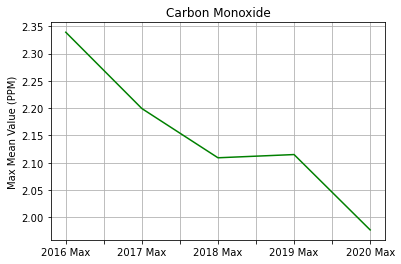

In [167]:
#drop lat and long, as not needed for further 
mean_drop=sum_stats.drop(labels=['2020 Mean','2019 Mean','2018 Mean','2017 Mean','2016 Mean'],axis=1)
row=mean_drop.iloc[1]
# row.plot(kind='bar')
plt.title('Carbon Monoxide')
plt.ylabel('Max Mean Value (PPM)')
row.plot(color='green')
plt.grid()
plt.savefig('Figures/mean_max.png')

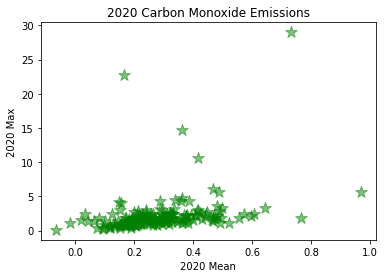

In [140]:
#generage scatter plot of mean v max values 

plt.scatter(pol_merge_16_20['2020 Mean'],pol_merge_16_20['2020 Max'],s=150,alpha=.5,color='green',marker='*')
plt.title('2020 Carbon Monoxide Emissions')
plt.xlabel('2020 Mean')
plt.ylabel('2020 Max')
plt.show()